# PREDICTING FACTORS THAT INFLUENCING PARKING IN NORTH AMERICAN CITIES

### Import all the required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import html5lib
import lxml
import requests
from bs4 import BeautifulSoup
import ast
from pandas.io.json import json_normalize

##### loading the parking data obtained from kaggle

In [7]:
df=pd.read_csv('Searching_for_parking_NA.csv')

In [8]:
df.head()

,Geohash,GeohashBounds,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Location,Latitude,Longitude,City,...,HourlyDistribution,SearchingByHour,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,PercentOther,UpdateDate,Version
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.030,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,...,"{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.000,0.600,0.200,0.000,0.200,2020-10-02,2.2
1,c3nfhhp,"POLYGON((-114.072418212891 50.99853515625, -11...",50.999,-114.072,51.000,-114.071,POINT(-114.07183 50.99918),50.999,-114.072,Calgary,...,"{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.222,0.778,0.000,0.000,0.000,2020-10-02,2.2
2,c3nfkkn,"POLYGON((-114.062805175781 51.04248046875, -11...",51.042,-114.063,51.044,-114.061,POINT(-114.06217 51.04336),51.043,-114.062,Calgary,...,"{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.5,0.000,0.333,0.000,0.000,0.167,2020-10-02,2.2
3,c3nfdmh,"POLYGON((-114.153442382812 51.0919189453125, -...",51.092,-114.153,51.093,-114.152,POINT(-114.15236 51.09233),51.092,-114.152,Calgary,...,"{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.750,0.125,0.000,0.125,0.000,2020-10-02,2.2
4,c3nfkjh,"POLYGON((-114.076538085938 51.0479736328125, -...",51.048,-114.077,51.049,-114.075,POINT(-114.07592 51.04845),51.048,-114.076,Calgary,...,"{""00"": null, ""01"": null, ""02"": null, ""03"": nul...","{""00"": null, ""01"": null, ""02"": null, ""03"": nul...",0.0,0.000,0.833,0.167,0.000,0.000,2020-10-02,2.2


##### Cleaning the original kaggle data since SearchingByHour and HourlyDistribution are in json object formats

In [9]:
#converting null to 0 for the selected columns
df['SearchingByHour']=df['SearchingByHour'].str.replace("null","0")
df['HourlyDistribution']=df['HourlyDistribution'].str.replace("null","0")

In [10]:
#converting the columns to string
df['SearchingByHour']=df['SearchingByHour'].apply(ast.literal_eval)
df['HourlyDistribution']=df['HourlyDistribution'].apply(ast.literal_eval)

In [11]:
#putting the JSON object into a workable format for pandas
dict_cols = pd.DataFrame(json_normalize(df["SearchingByHour"]).stack()).reset_index(level=1)
dict_cols.columns = ['hours_1','search_values']

dict_cols2 = pd.DataFrame(json_normalize(df["HourlyDistribution"]).stack()).reset_index(level=1)
dict_cols2.columns = ['hours','hd_values']

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


### Webscraping from wikipedia

In [12]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population')
tabs=table[0]

In [13]:
tabs.head()

,Unnamed: 0,City,Image,Country,Population,Year
0,1,Mexico City,NaN,Mexico,"8,918,653[a][3][4]",2015[b]
1,2,New York City,NaN,United States,"8,550,405[5]",2015
2,3,Los Angeles,NaN,United States,"3,971,883[5]",2015
3,4,Toronto,NaN,Canada,"2,826,498[c][7]",2015
4,5,Chicago,NaN,United States,"2,720,546[5]",2015


##### Cleaning the webscraped data

In [14]:
#removing the references from the population column
new = tabs['Population'].str.split("[", n = 1, expand = True) 
tabs["pop"]= new[0] 

In [15]:
#removing commas in the population column
tabs['pop']=tabs['pop'].apply(lambda x: float(x.split()[0].replace(",","")))

In [16]:
#for further merges or join New York city has to be edited 
tabs["City"]= tabs["City"].replace('New York City', "New York") 

In [17]:
#the pop column showing the cleaned up output of the initial population column
tabs.head()

,Unnamed: 0,City,Image,Country,Population,Year,pop
0,1,Mexico City,NaN,Mexico,"8,918,653[a][3][4]",2015[b],8918653.0
1,2,New York,NaN,United States,"8,550,405[5]",2015,8550405.0
2,3,Los Angeles,NaN,United States,"3,971,883[5]",2015,3971883.0
3,4,Toronto,NaN,Canada,"2,826,498[c][7]",2015,2826498.0
4,5,Chicago,NaN,United States,"2,720,546[5]",2015,2720546.0


### Webscraping GDP data 

In [18]:
gdps = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_by_GDP_(PPP)_per_capita')
gdp=gdps[0]
gdp.columns=['Metro_ID','City','GDP_per_capita']

In [19]:
gdp.head()

,Metro_ID,City,GDP_per_capita
0,USA05,San Francisco (Greater),94699
1,LU001,Luxembourg,88312
2,USA14,Seattle,78262
3,USA11,Boston,78183
4,USA01,New York (Greater),74244


##### Cleaning the GDP data

In [20]:
# removing references or brackets from the column
new = gdp['City'].str.split("(", n = 1, expand = True) 
gdp["City"]= new[0] 

#removing white spaces from the end of the data
gdp['City']=gdp['City'].str.rstrip()

In [21]:
gdp.head()

,Metro_ID,City,GDP_per_capita
0,USA05,San Francisco,94699
1,LU001,Luxembourg,88312
2,USA14,Seattle,78262
3,USA11,Boston,78183
4,USA01,New York,74244


##### merging the kaggle data and the webscraped data into one dataframe

In [25]:
#joining the columns to the df database
parking = pd.concat([df, dict_cols], axis=1)
parking=pd.concat([parking,dict_cols2],axis=1)

In [26]:
parking.head()

,Geohash,GeohashBounds,Latitude_SW,Longitude_SW,Latitude_NE,Longitude_NE,Location,Latitude,Longitude,City,...,PercentLDT,PercentMDT,PercentHDT,PercentOther,UpdateDate,Version,hours_1,search_values,hours,hd_values
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,...,0.6,0.2,0.0,0.2,2020-10-02,2.2,00,0.0,00,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,...,0.6,0.2,0.0,0.2,2020-10-02,2.2,01,0.0,01,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,...,0.6,0.2,0.0,0.2,2020-10-02,2.2,02,0.0,02,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,...,0.6,0.2,0.0,0.2,2020-10-02,2.2,03,0.0,03,0.0
0,c3nftjv,"POLYGON((-114.031219482422 51.0960388183594, -...",51.096,-114.031,51.097,-114.03,POINT(-114.03066 51.09692),51.097,-114.031,Calgary,...,0.6,0.2,0.0,0.2,2020-10-02,2.2,04,0.0,04,0.0


In [27]:
#joining the cleaned kaggle columns to the population data
allin=pd.merge(parking, tabs, how='left', on='City')
allin=allin.drop(['Image','Country_y','Population','Year'],axis=1)
allin=allin.dropna()

In [28]:
#joining the kaggle + population columns to the GDP per capita data
allin=pd.merge(allin, gdp, how='left', left_on='City', right_on='City')
allin=allin.dropna()

In [29]:
allin=allin.drop(['Version','Latitude_SW','Longitude_SW','Latitude_NE','Longitude_NE'],axis=1)
allin=allin.drop(['Country_x','PercentOther','UpdateDate','Metro_ID','GeohashBounds','Location'],axis=1)
allin=allin.drop(['Geohash','ISO_3166_2','City','County','State','CirclingDistribution','HourlyDistribution','SearchingByHour'],axis=1)
allin=allin.drop(['hours_1','Unnamed: 0','Latitude','Longitude'],axis=1)

In [30]:
allin.head()

,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,PercentSearching,AvgUniqueGeohashes,AvgTotalGeohashes,PercentCar,PercentMPV,PercentLDT,PercentMDT,PercentHDT,search_values,hours,hd_values,pop,GDP_per_capita
216,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,00,0.0,1563025.0,44725.0
217,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,01,0.0,1563025.0,44725.0
218,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,02,0.0,1563025.0,44725.0
219,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,03,0.0,1563025.0,44725.0
220,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,0.0,0.0,04,0.0,1563025.0,44725.0


### Feature Engineering
One hot encoding the hours column

In [31]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(allin[['hours']]).toarray())

# merge with main df bridge_df on key values
allin = allin.join(enc_df)

In [32]:
allin=allin.drop(['hours'],axis=1)

In [35]:
allin=allin.dropna()

In [36]:
allin.head()

,AvgTimeToPark,AvgTimeToParkRatio,TotalSearching,PercentSearching,AvgUniqueGeohashes,AvgTotalGeohashes,PercentCar,PercentMPV,PercentLDT,PercentMDT,...,14,15,16,17,18,19,20,21,22,23
216,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220,6.993,1.807,5,0.208,7.0,11.4,0.0,0.0,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Exploration

#### Distribution plot for the average time to park for the data set 

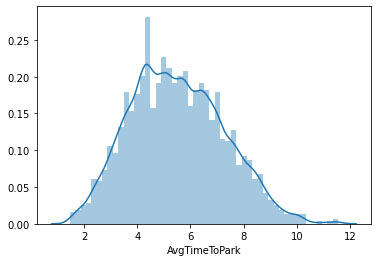

In [37]:
sns.distplot(a=allin['AvgTimeToPark'])
plt.savefig('distributionavgpark.png')

#### the distribution plot is fairly normal with a peak of 4.5mins. It is also slightly skewed to the left. 

#### Correlation heat map for the correlation plot for the features used in the model

In [39]:
parkcolumns = allin[[ 'AvgTimeToPark', 'AvgTimeToParkRatio',     'TotalSearching',
         'PercentSearching', 'AvgUniqueGeohashes',         'PercentCar',
               'PercentMPV',         'PercentLDT',         'PercentMDT',
               'PercentHDT',      'search_values',          'hd_values',
                      'pop',     'GDP_per_capita']]

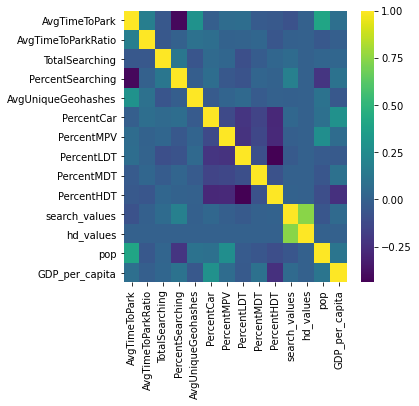

In [40]:

fig = plt.figure(figsize= (5,5))
sns.heatmap(parkcolumns.corr(), annot=False, vmax=1, cmap='viridis', square=False)
plt.savefig('correlationplot.png')

#### decision to drop avgtotalGeohashes as it is highly correlated to the Average time to park which is the target variable in this analysis

In [37]:
allin=allin.drop(['AvgTotalGeohashes'],axis=1)

In [38]:
allin=allin.dropna()

## Regression Analysis

### Linear Regression

In [44]:
#double check to make sure you import only once, no need for repetitions

In [39]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [40]:
X=allin.drop(['AvgTimeToPark'],axis=1)
y=allin.AvgTimeToPark

In [41]:
# Create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
#Transform data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [43]:
#Default linear regression

In [44]:
model = ElasticNet()
model.fit(X_train, y_train)

print(f"R^2 score on training set: {model.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {model.score(X_test, y_test):0.3f}")

R^2 score on training set: 0.105
R^2 score on test set: 0.105


In [57]:
#defining the coefficients of the dataset
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

In [58]:
coeff1=coeff_df.sort_values(by=['Coefficient'], ascending=False)

#### the most postive coefficients

In [59]:
coeff1.head()

,Coefficient
pop,0.125907
AvgTimeToParkRatio,0.000000
14,0.000000
8,-0.000000
9,-0.000000


#### the most negative coefficients

In [60]:
coeff1.tail()

,Coefficient
1,-0.000000
2,0.000000
3,-0.000000
23,-0.000000
PercentSearching,-0.128728


In [61]:
y_pred = model.predict(X_test)

In [62]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.353749593215758
Mean Squared Error: 2.7388367118251944
Root Mean Squared Error: 1.654943114377408


#### Hyper paramter tuning the linear regression to obtain the best linear model

In [87]:
# Create the hyperparameter grid

params = dict()

# values for alpha: 100 values between e^-5 and e^5
params['alpha'] =  np.logspace(-5, 5, 100, endpoint=True)

# values for l1_ratio: 100 values between 0 and 1
params['l1_ratio'] = np.arange(0, 1, 0.01)


# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(max_iter=10000, tol=0.001)

# Setup the GridSearchCV object: gm_cv
gm_cv = RandomizedSearchCV(elastic_net, params,n_iter=10, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_pred,y_test)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Tuned ElasticNet l1 ratio: {'l1_ratio': 0.46, 'alpha': 0.008497534359086439}
Tuned ElasticNet R squared: 0.37883149141314554
Tuned ElasticNet MSE: 1.901263989192625


In [88]:
gm_cv=ElasticNet(l1_ratio = 0.46,alpha=0.008)
gm_cv.fit(X_train, y_train)

ElasticNet(alpha=0.008, copy_X=True, fit_intercept=True, l1_ratio=0.46,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [89]:
acoeff_df = pd.DataFrame(gm_cv.coef_, X.columns, columns=['Coefficient'])

In [90]:
acoeff1=acoeff_df.sort_values(by=['Coefficient'], ascending=False)

In [91]:
acoeff1.head()

,Coefficient
pop,0.562007
AvgUniqueGeohashes,0.424834
AvgTimeToParkRatio,0.294738
GDP_per_capita,0.202653
PercentLDT,0.045269


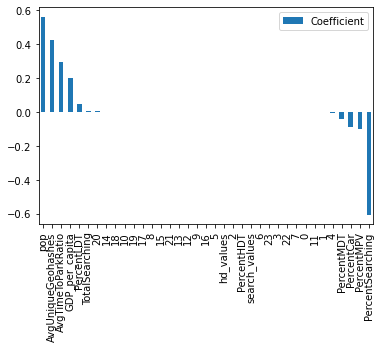

In [92]:
# Horizontal Bar Plot 
acoeff1.plot.bar()
  
# Show Plot 
plt.show() 

### Decision Tree Regression

#### Initial Decision tree regressor

In [94]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint

In [95]:
DTmodel = DecisionTreeRegressor()
DTmodel.fit(X_train, y_train)

print(f"R^2 score on training set: {DTmodel.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {DTmodel.score(X_test, y_test):0.3f}")

R^2 score on training set: 1.000
R^2 score on test set: 1.000


#### Optimized decision tree regression

In [100]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": range(1,100),
              "max_features": range(1, 37),
              "min_samples_leaf": range(1, 100),
              "criterion": ['mse']}


# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5, n_iter=10)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 9, 'max_features': 11, 'max_depth': 18, 'criterion': 'mse'}
Best score is 0.9634004877733294


In [101]:
y_preds = tree_cv.predict(X_test)

In [102]:
from sklearn import metrics

print('R2_score:', metrics.r2_score(y_test, y_preds))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

R2_score: 0.9646480536220957
Mean Absolute Error: 0.1044803888991423
Mean Squared Error: 0.10820474906090631
Root Mean Squared Error: 0.3289449027738632


### Feature importance for the Best Decision tree model

In [109]:
DTmodels = DecisionTreeRegressor(min_samples_leaf=9, max_features=11, max_depth = 18)
DTmodels.fit(X_train, y_train)

print(f"R^2 score on training set: {DTmodels.score(X_train, y_train):0.3f}")
print(f"R^2 score on test set: {DTmodels.score(X_test, y_test):0.3f}")

R^2 score on training set: 0.977
R^2 score on test set: 0.974


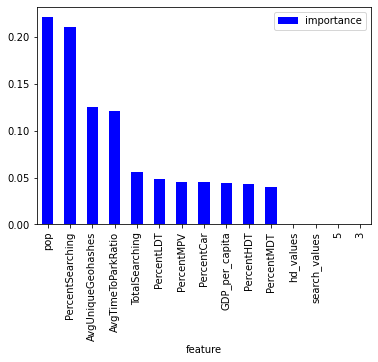

In [110]:
importances = DTmodels.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')
plt.savefig('decisontreeimportantfeatures.png')

#### initial random forest regressor

In [111]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_validate

In [112]:
#fitting the initial random forest regressor to the training data
random = RandomForestRegressor()
random.fit(X_train, y_train)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [113]:
y_preda = random.predict(X_test)

In [114]:
from sklearn import metrics

print('R2_score:', metrics.r2_score(y_test, y_preda))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preda))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preda))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preda)))

R2_score: 1.0
Mean Absolute Error: 6.349364781017752e-16
Mean Squared Error: 8.284171198040702e-31
Root Mean Squared Error: 9.101742249723786e-16


#### Another Random Forest Regressor using RandomizedsearchCV

In [115]:
random_grid = {"max_depth": range(1,100),
              "max_features": range(1,37),
              "min_samples_leaf": range(1,100),
               'n_estimators':range(1,100),
              "criterion": ['mse']}

#make sure you tune n_estimators for random forest 

In [118]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5,n_iter=10)

# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': 71,
 'min_samples_leaf': 12,
 'max_features': 26,
 'max_depth': 13,
 'criterion': 'mse'}

In [119]:
ans = rf_random.predict(X_test)

In [120]:
from sklearn import metrics

print('r2_score:', metrics.r2_score(y_test, ans))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ans))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ans))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ans)))

r2_score: 0.9616764015829949
Mean Absolute Error: 0.247110148830652
Mean Squared Error: 0.11730034056667439
Root Mean Squared Error: 0.3424913729813853


#### Feature importance based on the optimized random forest model

In [121]:
#best parameter random forest model
best_rf = RandomForestRegressor(n_estimators=71,
 min_samples_leaf= 12,
 max_features= 26,
 max_depth= 13)

In [122]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features=26, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=12,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=71, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

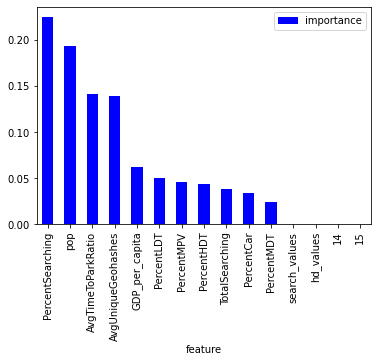

In [123]:
importances = best_rf.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar',color='blue')
plt.savefig('rfmodel.png')